In [1]:
import tensorflow as tf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

MODEL_PATH = "models/recognition/"

In [2]:
height = 28
width = 28
channels = 1
n_inputs = height * width

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, n_inputs) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, n_inputs) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
nb_samples_taken = 2000
X_train = X_train[:nb_samples_taken]
y_train = y_train[:nb_samples_taken]

In [5]:
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2

conv3_fmaps = 128
conv3_ksize = 3
conv3_stride = 2

pool3_fmaps = conv3_fmaps

n_fc1 = 128
n_outputs = 10

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv2")
conv3 = tf.layers.conv2d(conv2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv3")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 3 * 3])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy_train = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_test = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    tf.summary.scalar('accuracy_train', accuracy_train)
    tf.summary.scalar('accuracy_test', accuracy_test)

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

W0730 14:34:15.538490  5988 deprecation.py:323] From <ipython-input-5-e27571fbe597>:25: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0730 14:34:15.545507  5988 deprecation.py:506] From C:\Users\antho\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0730 14:34:15.882807  5988 deprecation.py:323] From <ipython-input-5-e27571fbe597>:38: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [6]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [8]:
n_epochs = 10
batch_size = 100

now = datetime.now()
logdir = "tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

with tf.Session() as sess:
    merged = tf.summary.merge_all()
    tf_tensorboard_writer = tf.summary.FileWriter('./'+logdir, sess.graph)
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})       
        print(epoch, "Last batch accuracy:", accuracy_train.eval(feed_dict={X: X_batch, y: y_batch}), "Test accuracy:", accuracy_test.eval(feed_dict={X: X_test, y: y_test}))
        
        summary_str = sess.run(merged, feed_dict={X: X_batch, y: y_batch})
        tf_tensorboard_writer.add_summary(summary_str, epoch) 
        save_path = saver.save(sess, MODEL_PATH + "model3conv")
        
tf_tensorboard_writer.close()


0 Last batch accuracy: 0.74 Test accuracy: 0.7167
1 Last batch accuracy: 0.85 Test accuracy: 0.8679
2 Last batch accuracy: 0.93 Test accuracy: 0.8962
3 Last batch accuracy: 0.98 Test accuracy: 0.9305
4 Last batch accuracy: 0.95 Test accuracy: 0.9357
5 Last batch accuracy: 0.97 Test accuracy: 0.9462
6 Last batch accuracy: 0.98 Test accuracy: 0.9467
7 Last batch accuracy: 1.0 Test accuracy: 0.9417
8 Last batch accuracy: 1.0 Test accuracy: 0.9356
9 Last batch accuracy: 1.0 Test accuracy: 0.9469


# Increasing dataset with rotation and zoom

In [27]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

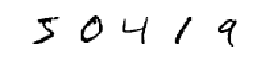

In [48]:
X_reshaped = tf.reshape(X_train, shape=[-1, height, width, channels])
plt.figure(figsize=(8,50)) # not shown in the book
with tf.Session() as sess:
    X_reshaped = X_reshaped.eval()
for iteration in range(5):
    plt.subplot(5, 10, iteration + 1)
    plot_image(X_reshaped[iteration])

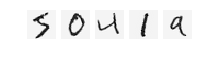

In [50]:
from scipy.ndimage import rotate
for iteration in range(5):
    plt.subplot(5, 10, iteration + 1)
    plot_image(rotate(X_reshaped[iteration], 20, reshape=False))